In [3]:
import os
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision import transforms
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import json


# Dataset, dataloader

In [4]:
class MyDataset(Dataset):
    def __init__(self, train=True, transform=None, target_transform=None):
        self.img_dir = 'datasets/five_k_expert_a_small/image_lab/'
        if train:
            self.label_dir = 'datasets/five_k_expert_a_small/train_data.json'
        else:
            self.label_dir = 'datasets/five_k_expert_a_small/test_data.json'
            
        with open(self.label_dir) as f:
            self.image_fn_and_illuminant = json.load(f)

        self.transform = transform

    def __len__(self):
        return len(self.image_fn_and_illuminant)

    def __getitem__(self, index):
        image_fn, illuminant = self.image_fn_and_illuminant[index]
        
        # Read image
        path = os.path.join(self.img_dir, image_fn)
        image = read_image(path) / 255
        
        # Apply transform
        if self.transform:
            image = self.transform(image)
        
        # Convert to float32 (not use float64)
        return image.to(torch.float32), torch.tensor(illuminant)

In [5]:
my_transforms = transforms.Compose([
    transforms.Resize((128, 128))
])

train_dataloader = DataLoader(MyDataset(train=True, transform=my_transforms), 64, shuffle=True)
test_dataloader = DataLoader(MyDataset(train=False, transform=my_transforms), 64, shuffle=True)

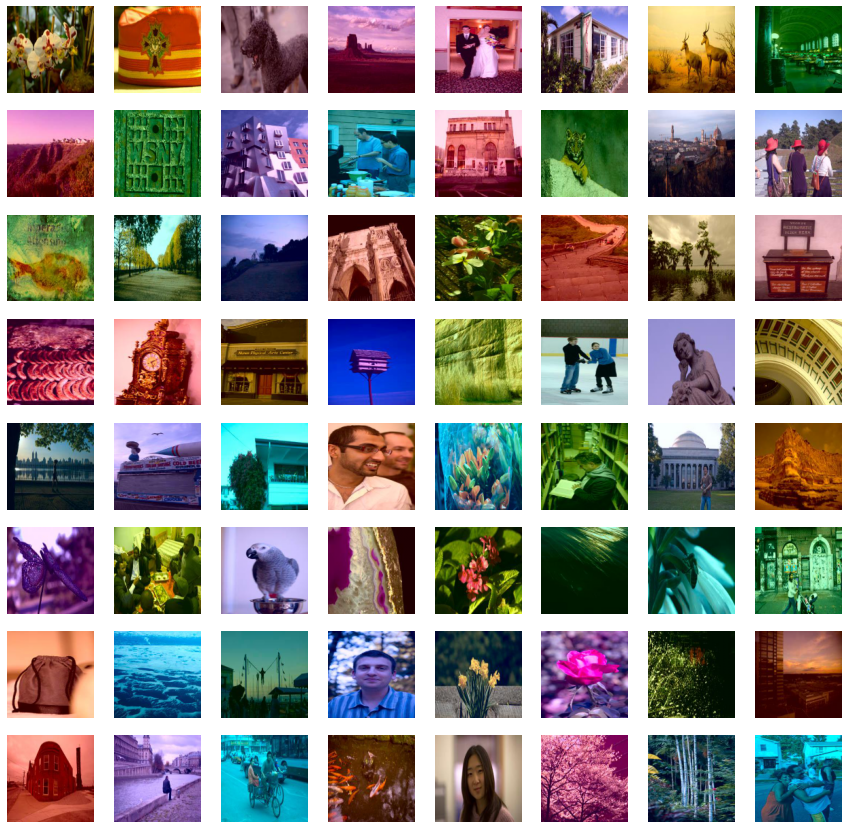

In [4]:
# Show batch
plt.figure(figsize=(15, 15))
images, labels = next(iter(train_dataloader))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    image = torch.permute(images[i], (1, 2, 0))
    plt.imshow(image)
    plt.axis("off")

# Estimate-Color Network

In [6]:
class EstimateColorNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 24, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(24, 24, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(24, 48, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(48, 48, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(48, 96, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(96, 192, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(192, 192, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.lastblock = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8*8*192, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.lastblock(x)
        return x

    

# Criterion, optimizer

In [6]:
EPS = 1e-9
PI = 22.0 / 7.0

def angular_loss(predicted, gt, shrink=True):
  """ Computes angular error between predicted and gt illuminant color(s)

  Args:
    predicted: n x 3 tensor of predicted illuminant colors; where n is the
      total number of predicted illuminant colors.
    gt: n x 3 tensor of corresponding ground-truth true illuminant colors.
    shrink: to use angle shrink for training; default is True.

  Returns:
    a_error: mean angular error between predicted and gt illuminant colors.
  """

  cossim = torch.clamp(torch.sum(predicted * gt, dim=1) / (
      torch.norm(predicted, dim=1) * torch.norm(gt, dim=1) + EPS), -1, 1.)
  if shrink:
    angle = torch.acos(cossim * 0.9999999)
  else:
    angle = torch.acos(cossim)
  a_error = 180.0 / PI * angle
  a_error = torch.sum(a_error) / a_error.shape[0]
  return a_error

In [7]:
device = 'cuda'
model = EstimateColorNetwork().to(device)

loss_weight = [1, 250]

def loss_fn(outputs, targets):
    ang_loss = angular_loss(outputs, targets)
    mse_loss = torch.square(outputs - targets).mean()
    return loss_weight[0] * ang_loss + loss_weight[1] * mse_loss
    

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Train

In [8]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter('runs/Estimate_ab_{}'.format(timestamp))
n_epochs = 200

def train_one_epoch(epoch_index):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        if torch.isnan(outputs).any():
            raise Exception("Output is NaN")
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:
            last_loss = running_loss / 10 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_dataloader) + i + 1
            writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    writer.flush()
    return last_loss

def validation():
    running_loss = 0.0
    for i, data in enumerate(test_dataloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        running_loss += loss.item()
    avg_loss = running_loss / (i + 1)
    return avg_loss

for epoch_index in range(n_epochs):
    print('EPOCH {}:'.format(epoch_index))

    model.train(True)
    train_loss = train_one_epoch(epoch_index)
    model.train(False)
    val_loss = validation()

    print('LOSS train {} valid {}'.format(train_loss, val_loss))
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : train_loss, 'Validation' : val_loss },
                    epoch_index + 1)
    writer.flush()


EPOCH 0:
  batch 10 loss: 41.675846862792966
  batch 20 loss: 39.59373512268066
  batch 30 loss: 40.84209938049317
  batch 40 loss: 40.78641357421875
  batch 50 loss: 40.63890266418457
LOSS train 40.63890266418457 valid 39.74769417444865
EPOCH 1:
  batch 10 loss: 40.83549690246582
  batch 20 loss: 41.4758544921875
  batch 30 loss: 40.10976104736328
  batch 40 loss: 40.00238380432129
  batch 50 loss: 39.83711395263672
LOSS train 39.83711395263672 valid 39.75419314702352
EPOCH 2:
  batch 10 loss: 39.67817764282226
  batch 20 loss: 40.33105888366699
  batch 30 loss: 41.58868217468262
  batch 40 loss: 39.860941314697264
  batch 50 loss: 40.182559967041016
LOSS train 40.182559967041016 valid 39.032741705576576
EPOCH 3:
  batch 10 loss: 40.027428817749026
  batch 20 loss: 38.778086471557614
  batch 30 loss: 39.102690887451175
  batch 40 loss: 36.00608863830566
  batch 50 loss: 35.909092330932616
LOSS train 35.909092330932616 valid 33.36125302314758
EPOCH 4:
  batch 10 loss: 33.50805854797363

# Save & load

In [9]:
model_path = 'checkpoints/model_{}.pth'.format(timestamp)
torch.save(model.state_dict(), model_path)
print("Saved " + model_path)

Saved checkpoints/model_20220831_144540.pth


In [8]:
model = EstimateColorNetwork()
model.load_state_dict(torch.load("checkpoints/model_20220831_144540.pth"))
model.eval()

EstimateColorNetwork(
  (block1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block4): Sequential(
    (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

# Inference

In [11]:
from skimage.color import rgb2lab, lab2rgb
from skimage.io import imread
AMPLITUDE = 100


def infer(image):
    '''image: (w,h,3) np array'''
    input = torch.tensor(image)
    input = torch.permute(input, (2, 0, 1))
    input = torch.unsqueeze(input, 0)
    if my_transforms:
        input = my_transforms(input).to(torch.float32)

    with torch.no_grad():
        output = model(input)
    estimated_illuminant = output[0].numpy()

    out_image = rgb2lab(image)
    out_image[:,:,1:] -= AMPLITUDE * (estimated_illuminant - 0.5)
    out_image = lab2rgb(out_image)
    return out_image

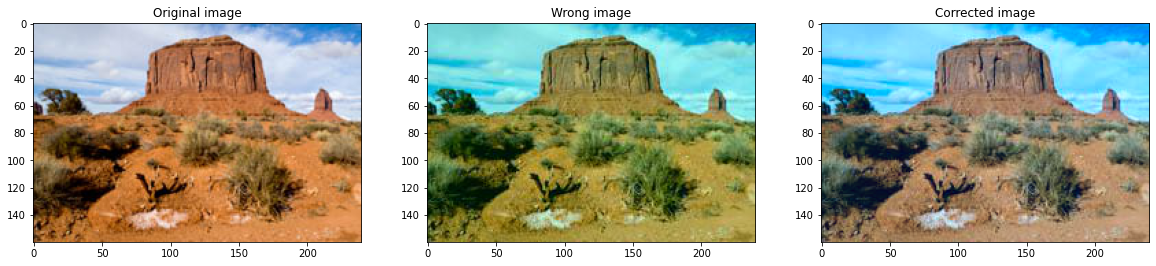

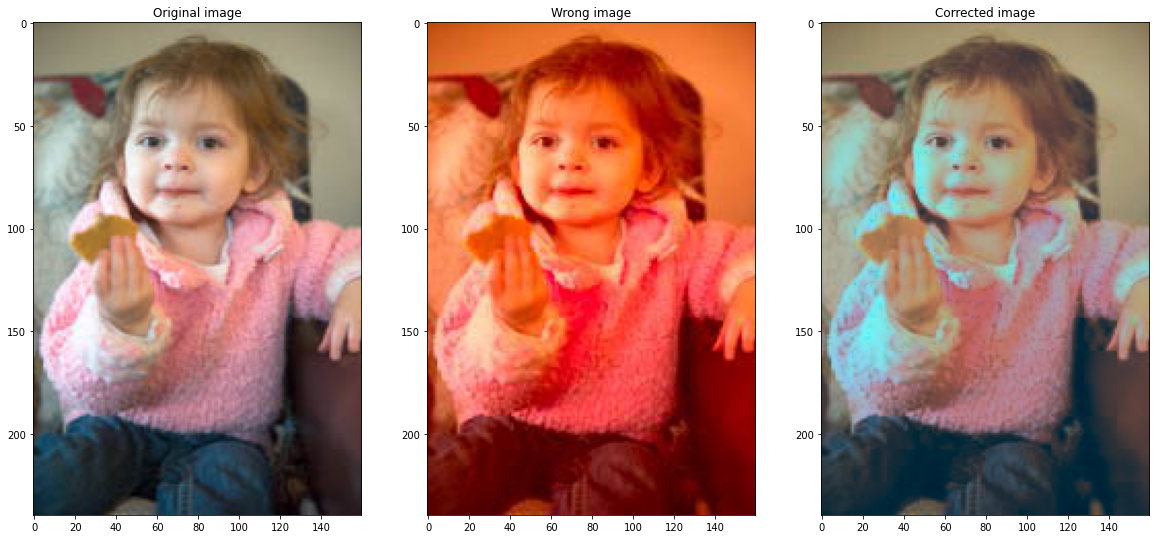

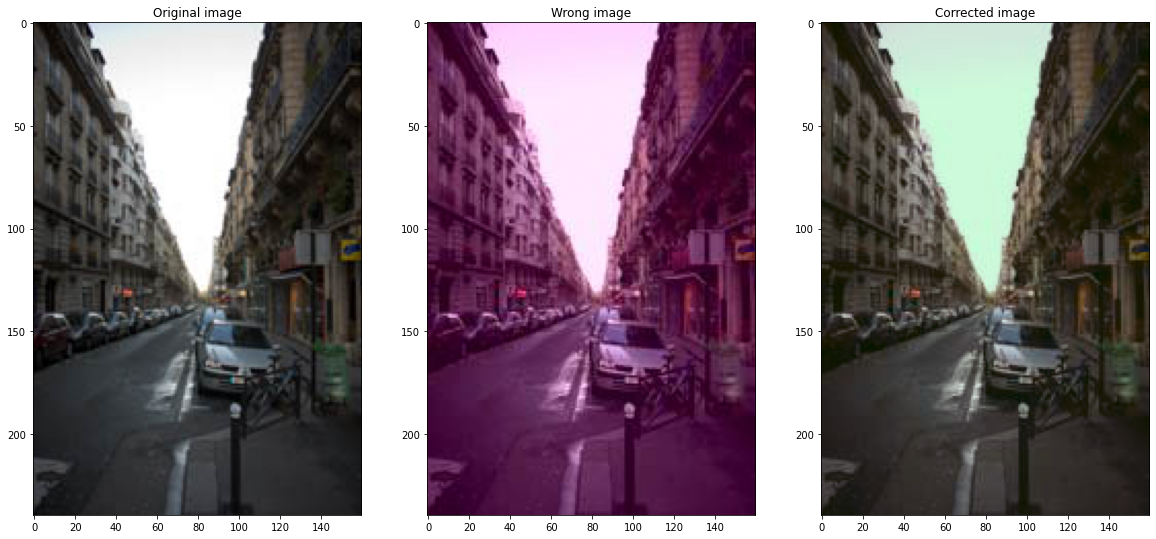

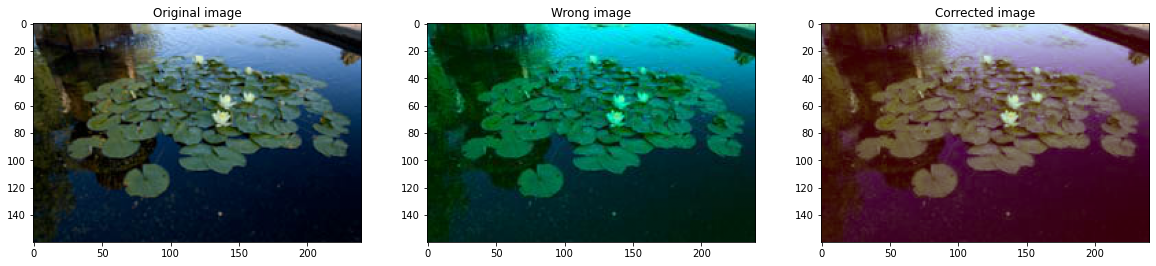

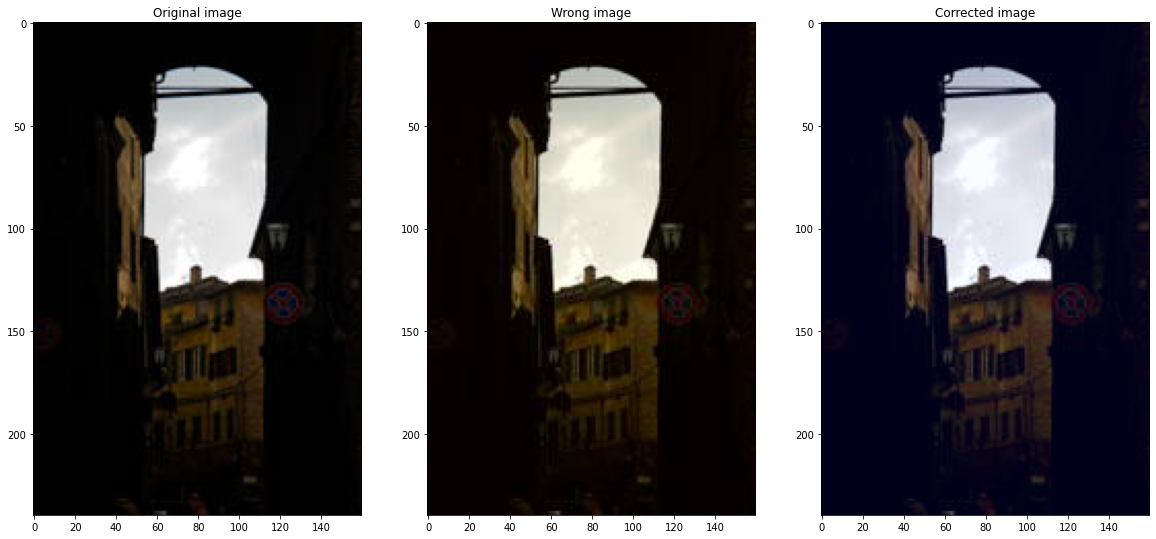

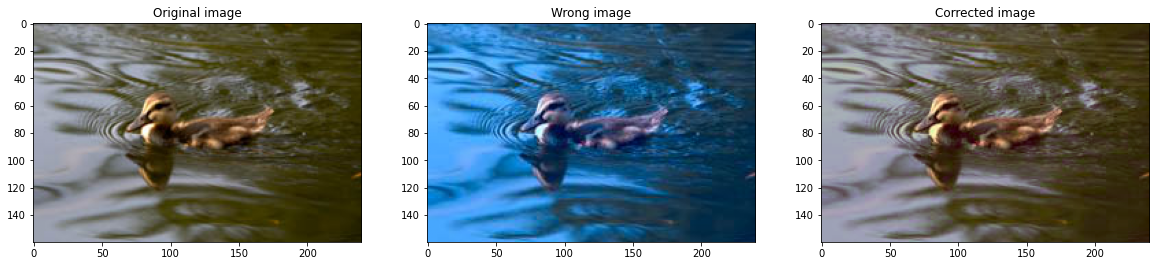

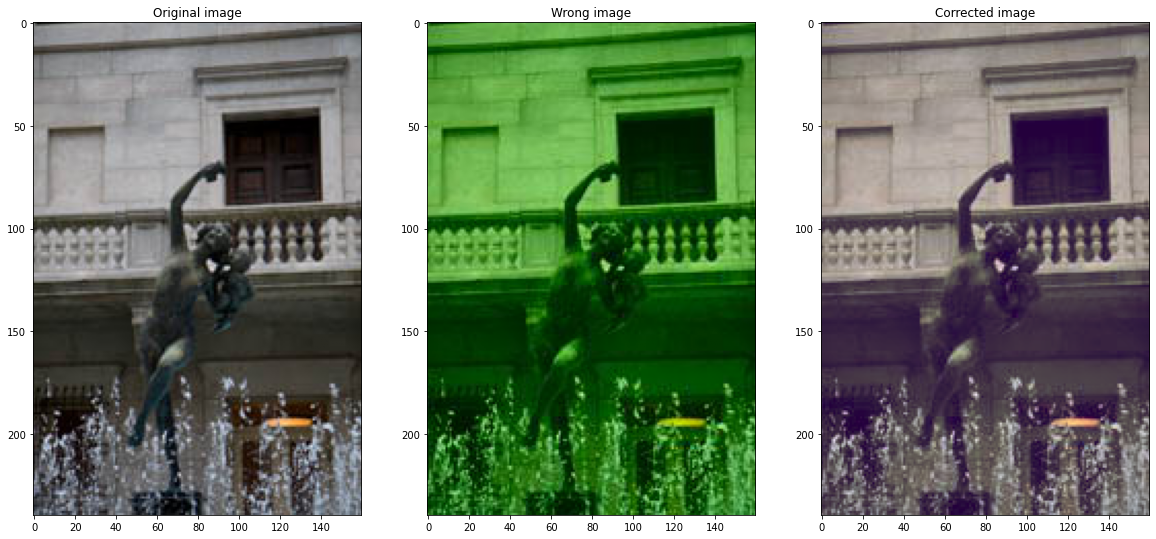

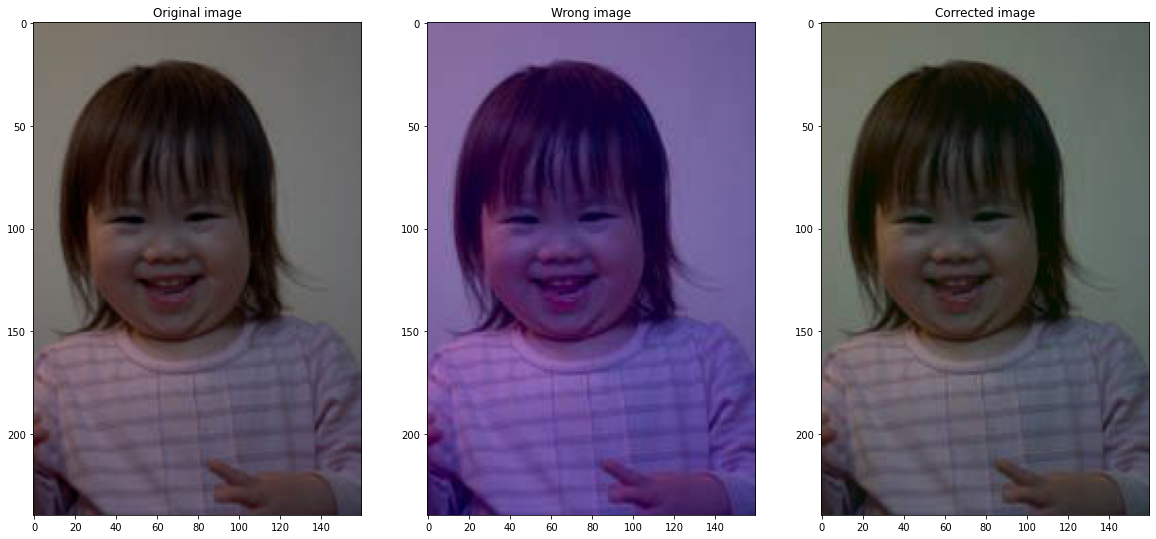

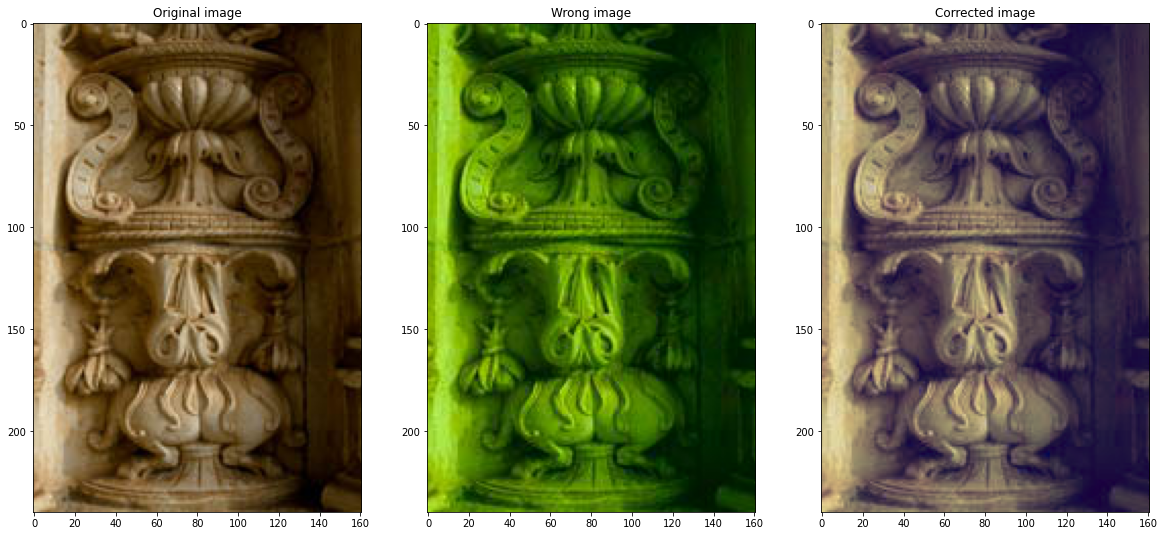

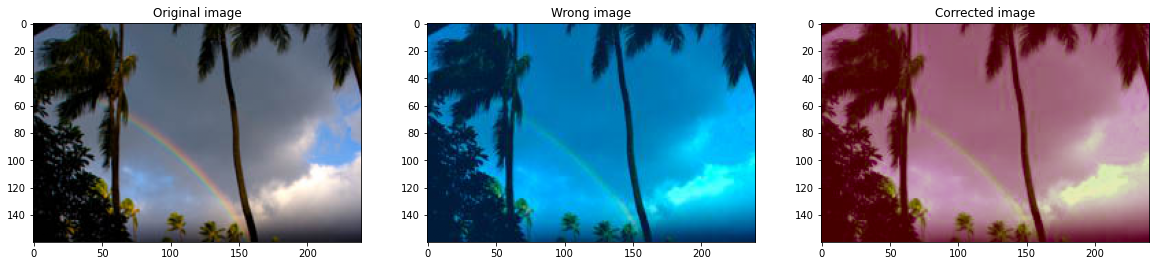

In [22]:
imgs = os.listdir('datasets/five_k_expert_a_small/images')

for i in range(0, 10):
    image = imread(os.path.join('datasets/five_k_expert_a_small/images',imgs[i])) / 255
    distorted_image = imread(os.path.join('datasets/five_k_expert_a_small/image_lab',imgs[i])) / 255
    infered_image = infer(distorted_image)

    plt.figure(figsize=(20, 20))
    plt.subplot(1,3,1), plt.imshow(image)
    plt.title("Original image")
    plt.subplot(1,3,2), plt.imshow(distorted_image)
    plt.title("Wrong image")
    plt.subplot(1,3,3), plt.imshow(infered_image)
    plt.title("Corrected image")
    plt.show()

c:\Users\dranh\anaconda3\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 9678 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


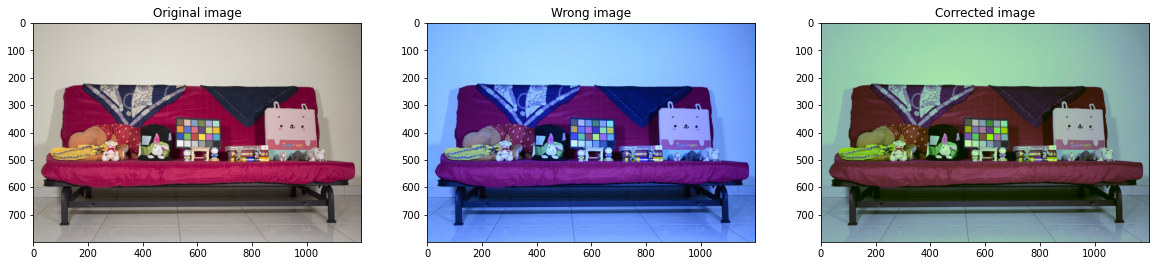

In [13]:
image = imread('images/NikonD5200_Indoor_Scene_18_6500_G_AS.png') / 255
# distorted_image = imread(os.path.join('datasets/five_k_expert_a_small/image_lab',imgs[i])) / 255
distorted_image = imread('images/NikonD5200_Indoor_Scene_18_6500_T_V.jpg') / 255
infered_image = infer(distorted_image)

plt.figure(figsize=(20, 20))
plt.subplot(1,3,1), plt.imshow(image)
plt.title("Original image")
plt.subplot(1,3,2), plt.imshow(distorted_image)
plt.title("Wrong image")
plt.subplot(1,3,3), plt.imshow(infered_image)
plt.title("Corrected image")
plt.show()